In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

# Plot Parameters

In [2]:
#parameters
plotdir = "./plots"
font = { 'size'   : 15}
plt.rc('font', **font)
markersize = 10 #12

#markers
colors = ['b','r','g','m','y','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

#styledict
styledict = {"thorsten": {"fontsize_annotation": 10, "roof_color": 'gray', "legend_points_ncol": 2, "frameon": False}, 
             "charlene": {"fontsize_annotation": 15, "roof_color": 'k', "legend_points_ncol": 1, "frameon": True}}

# Plot Code

In [3]:
#plot roofs
def plot_roofs(fig, ax, xlim, ylim, styledict, scaling = 1.):
    #extract general settings
    fontsize_annotation = styledict["fontsize_annotation"] #10
    roof_color = styledict["roof_color"]
    
    #set up roofs
    #mem
    #smemroofs = [14*1024, 2996.77, 828.758]
    #smem_roof_name = ['L1', 'L2', 'HBM']
    smemroofs = [828.758]
    smem_roof_name = ['HBM']
    #flops
    scomproofs_fp64 = [7669.86, 3535.79]
    #scomproofs_fp64 = [x*10**-3 for x in scomproofs_fp64]
    scomp_roof_name_fp64 = ['FMA (FP64)', 'No-FMA (FP64)']
    scomproofs_fp32 = [15158.6, 7669.1]
    scomp_roof_name_fp32 = ['FMA (FP32)', 'No-FMA (FP32)']
    scomproofs_fp16 = [106496.0] + [29181.6, 15158.6]
    scomp_roof_name_fp16 = ['Tensor Core (FP16)', 'FMA (FP16)', 'No-FMA (FP16)']
    scalingFactorForRoofs = scaling
    
    #resolution
    #nx = 10000
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    nx = 10*xmax
    
    #set limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    #plot roofs:
    dx = (xmax-xmin)/nx
    for idm, smem in enumerate(smemroofs):
        
        #fp32
        for idc, scomp in enumerate(scomproofs_fp32):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            #find elbow
            optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
            xelb = optimize["x"][0]
            yelb = min(smem*xelb, scomp)
            #if idm==0:
                #plot scomp
                #label = scomp_roof_name_fp32[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                #ax.annotate(label, xy=(xelb,scomp), xytext=(17,5), textcoords="offset points", color=roof_color, horizontalalignment='left', fontsize=fontsize_annotation)
        #fp16
        for idc, scomp in enumerate(scomproofs_fp16):
            xvals = np.arange(xmin, xmax, dx)
            yvals = np.minimum(smem*xvals, np.tile(np.array(scomp),len(xvals)))
            ax.plot(xvals, yvals, c=roof_color, ls='-', lw='2')
            #if idm==0:
                #plot scomp
                #label = scomp_roof_name_fp16[idc] + ': ' + '{0:.1f}'.format(float(scomp*10**-3)/scalingFactorForRoofs) + ' TFLOP/s'
                #ax.annotate(label, xy=(xmax,scomp), xytext=(-5,5), textcoords="offset points", color=roof_color, horizontalalignment='right', fontsize=fontsize_annotation)
        
        #plot mem
        #find intersection
        scomp = scomproofs_fp16[0]
        yis = ymin
        xis = minimize(fun = lambda x: np.abs(min([smem*x,scomp])-yis), x0=xmin, tol=1.e-10)["x"][0]
        #find elbow
        optimize = minimize(fun=lambda x: np.abs(smem*x-scomp), x0=xmin, tol=1.e-10)
        xelb = optimize["x"][0]
        yelb = min(smem*xelb, scomp)
        yy = min(smem*xmin, scomp)
        #yy = yelb - (yelb - yis) / (xelb - xis) * (xelb - xmin)
        #angle in plot coord system
        ang = np.rad2deg( np.arctan2(yelb-yis, xelb-xis) )
        #angle in figure coord system
        pts = np.array((xelb, yelb)).reshape((1,2))
        trans_ang = 26#ax.transData.transform_angles(np.array((ang,)), pts)[0]
        #ax.plot(xis, yis, marker="o", ms=10)
        #ax.plot(xelb, yelb, marker="o", ms=10)
        label = smem_roof_name[idm] + ': ' + '{0:.1f}'.format(float(smem)/scalingFactorForRoofs) + ' GB/s'
        ax.annotate(label, xy=(xmin, yy), xytext=(3,-5), color=roof_color, \
                rotation=trans_ang, rotation_mode='anchor', \
                horizontalalignment='left', \
                verticalalignment='top', \
                textcoords="offset points", \
                fontsize=fontsize_annotation)

In [4]:
#data dependent stuff
def plot_data(file_prefix, plot_label, marker_tag, marker_label, df):
    
    #pick style:
    style = styledict["thorsten"]
    
    # PyTorch data
    df_pt = df[ df["Framework"]=="PT" ]
    # TF1 data
    df_tf1 = df[ df["Framework"]=="TF1" ]
    # TF2 data
    df_tf2 = df[ df["Framework"]=="TF2" ]
    
    #fp32 data
    df_pt_fp32 = df_pt[ df_pt["Precision"]=="FP32" ]
    df_tf1_fp32 = df_tf1[ df_tf1["Precision"]=="FP32" ]
    df_tf2_fp32 = df_tf2[ df_tf2["Precision"]=="FP32" ]
    
    AI_pt_fp32 = list(df_pt_fp32["DRAM AI"]) #list(df_fp32["FP32 DRAM AI"])
    FLOPs_pt_fp32 = list(df_pt_fp32["Performance GFlop/s"]) #list(df_fp32["FP32 Performance GFlop/s"])
    AI_tf1_fp32 = list(df_tf1_fp32["DRAM AI"])
    FLOPs_tf1_fp32 = list(df_tf1_fp32["Performance GFlop/s"])
    AI_tf2_fp32 = list(df_tf2_fp32["DRAM AI"])
    FLOPs_tf2_fp32 = list(df_tf2_fp32["Performance GFlop/s"])
    
    labels_fp32 = ["FP32 "+marker_label+" "+str(x) for x in list(df_pt_fp32[marker_tag])]
    #print(labels_fp32)
    
    #fp16 data
    df_pt_fp16 = df_pt[ df_pt["Precision"]=="FP16" ]
    df_tf1_fp16 = df_tf1[ df_tf1["Precision"]=="FP16" ]
    df_tf2_fp16 = df_tf2[ df_tf2["Precision"]=="FP16" ]
    
    AI_pt_fp16 = list(df_pt_fp16["DRAM AI"]) #list(df_fp32["FP32 DRAM AI"])
    FLOPs_pt_fp16 = list(df_pt_fp16["Performance GFlop/s"]) #list(df_fp32["FP32 Performance GFlop/s"])
    AI_tf1_fp16 = list(df_tf1_fp16["DRAM AI"])
    FLOPs_tf1_fp16 = list(df_tf1_fp16["Performance GFlop/s"])
    AI_tf2_fp16 = list(df_tf2_fp16["DRAM AI"])
    FLOPs_tf2_fp16 = list(df_tf2_fp16["Performance GFlop/s"])
    
    labels_fp16 = ["FP16 "+marker_label+" "+str(x) for x in list(df_pt_fp16[marker_tag])]
    #print(labels_fp16)
    
    #figure stuff
    fig = plt.figure(1,figsize=(10.6,6.7))
    plt.clf()
    ax = fig.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Arithmetic Intensity [FLOP/Byte]')
    ax.set_ylabel('Performance [GFLOP/s]')
    xmin = -1 #np.floor(np.log(min(AI_l1))) #-2
    xmax = 2 #np.ceil(np.log(max(AI_dram)))
    ymin = 1 #max(min([6500.0*0.5]+[0.5*x for x in FLOPs_fp32]+[0.5*x for x in FLOPs_fp16]), 500.0) #10./scalingFactorForRoofs #10.0 / scalingFactorForRoofs
    ymax = 5000 #max(FLOPs)*2./scalingFactorForRoofs
    
    #some handles
    marker_handles = []
    
    #plot roofs
    plot_roofs(fig, ax, (10**xmin, 10**xmax), (ymin, ymax), style)
    
    #FP32
    for i in range(0,len(AI_pt_fp32)):
        ax.plot(float(AI_pt_fp32[i]),float(FLOPs_pt_fp32[i]),c=colors[0],marker=styles[i], mfc='none',linestyle='None',ms=markersize,label=labels_fp32[i])
    ax.plot((AI_pt_fp32),(FLOPs_pt_fp32),c=colors[0],linestyle='-')
    for i in range(0,len(AI_tf1_fp32)):
        ax.plot(float(AI_tf1_fp32[i]),float(FLOPs_tf1_fp32[i]),c=colors[1],marker=styles[i], mfc='none',linestyle='None',ms=markersize,label=labels_fp32[i])
    ax.plot((AI_tf1_fp32),(FLOPs_tf1_fp32),c=colors[1],linestyle='-')
    for i in range(0,len(AI_tf2_fp32)):
        ax.plot(float(AI_tf2_fp32[i]),float(FLOPs_tf2_fp32[i]),c=colors[2],marker=styles[i], mfc='none', linestyle='dashed',ms=markersize,label=labels_fp32[i])
        marker_handles.append(ax.plot([],[],c='gray',marker=styles[i], mfc='none', linestyle='None',ms=markersize,label=labels_fp32[i])[0])
    ax.plot((AI_tf2_fp32),(FLOPs_tf2_fp32),c=colors[2],linestyle='-')

    
    #FP16
    for i in range(0,len(AI_pt_fp16)):
        ax.plot(float(AI_pt_fp16[i]),float(FLOPs_pt_fp16[i]),c=colors[0],marker=styles[i], linestyle='None',ms=markersize,label=labels_fp16[i])
    ax.plot((AI_pt_fp16),(FLOPs_pt_fp16),c=colors[0],linestyle='-')
    for i in range(0,len(AI_tf1_fp16)):
        ax.plot(float(AI_tf1_fp16[i]),float(FLOPs_tf1_fp16[i]),c=colors[1],marker=styles[i], linestyle='None',ms=markersize,label=labels_fp16[i])
    ax.plot((AI_tf1_fp16),(FLOPs_tf1_fp16),c=colors[1],linestyle='-')
    for i in range(0,len(AI_tf2_fp16)):
        ax.plot(float(AI_tf2_fp16[i]),float(FLOPs_tf2_fp16[i]),c=colors[2],marker=styles[i], linestyle='dashed',ms=markersize,label=labels_fp16[i])
        marker_handles.append(ax.plot([],[],c='gray',marker=styles[i], linestyle='None',ms=markersize,label=labels_fp16[i])[0])
    ax.plot((AI_tf2_fp16),(FLOPs_tf2_fp16),c=colors[2],linestyle='-')
    
    #annotations
    #legend 1
    leg1 = plt.legend(handles = marker_handles, loc="upper right", ncol=style["legend_points_ncol"], frameon=style["frameon"])
    ax.add_artist(leg1)
    
    #legend 2:
    patch_handles = []
    patch_handles.append(mpatches.Patch(color=colors[0],label = 'PT'))
    patch_handles.append(mpatches.Patch(color=colors[1],label = 'TF1'))
    patch_handles.append(mpatches.Patch(color=colors[2],label = 'TF2'))
    leg2 = plt.legend(handles = patch_handles,loc='lower right', scatterpoints = 1, frameon=style["frameon"])
    
    #title
    if plot_label:
        ax.text(ax.get_xlim()[0]*1.1, ax.get_ylim()[1]*1.5, plot_label, horizontalalignment='left', verticalalignment='top')
    
    #plt.show()
    
    #save figure
    plt.tight_layout()
    #plt.savefig(file_prefix+'.png')
    plt.savefig(file_prefix+'.eps')

# Load Data

In [5]:
tf1_datadir = "/global/cfs/cdirs/m1759/yswang/results/rnn1d-tf1-noxla"
tf2_datadir = "/global/cfs/cdirs/m1759/yswang/results/rnn1d-tf2-noxla"
pt_datadir = "/global/cfs/cdirs/m1759/yswang/results/rnn1d-pt-noxla"
outputdir = "/global/cfs/cdirs/m1759/yswang/plots/summary/"
tf1df = pd.read_csv(os.path.join(tf1_datadir,"combined_profile.csv"))
tf2df = pd.read_csv(os.path.join(tf2_datadir,"combined_profile.csv"))
ptdf = pd.read_csv(os.path.join(pt_datadir,"combined_profile.csv"))
combineddf = pd.concat([tf1df, tf2df, ptdf])

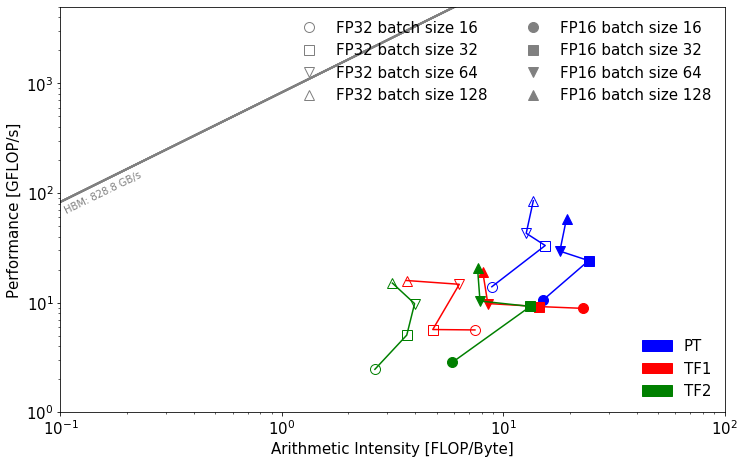

In [6]:
#plot vs batchsize
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)
    
features = list(combineddf[["Time Steps", "Features", "Hidden Size", "Pass"]].apply(lambda x: (x["Time Steps"], \
                                                                                          x["Features"], \
                                                                                          x["Hidden Size"], \
                                                                                          x["Pass"]), axis=1).unique())

for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Time Steps" ] == feature[0]) & \
                           (combineddf[ "Features" ] == feature[1]) & \
                           (combineddf[ "Hidden Size" ] == feature[2]) & \
                           (combineddf[ "Pass" ] == feature[3]) ].copy()
    
    #sort data
    selectdf.sort_values("Batch Size", ascending=True, inplace=True)
    
    if len(selectdf["Batch Size"].unique()) == 1:
        continue
    
    #label
    plot_label = 'lstm, t'+str(feature[0])+', f'+str(feature[1])+', h'+str(feature[2])+', '+str(feature[3])
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    #display(selectdf)
    plot_data(plot_file, plot_label, "Batch Size", "batch size", selectdf)

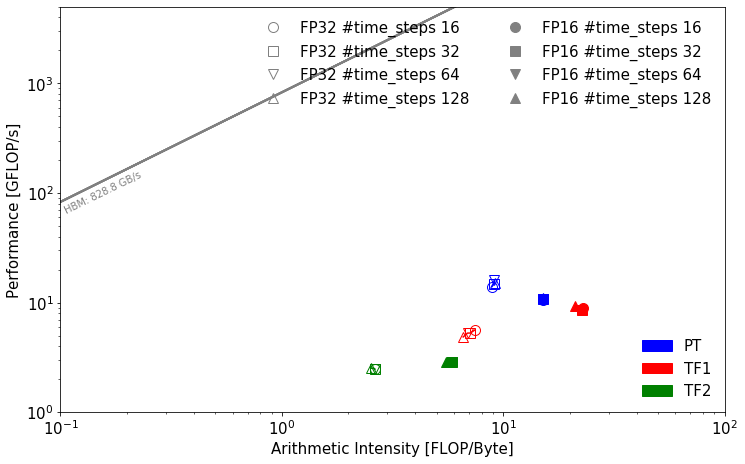

In [7]:
#plot vs num filters
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)

    
features = list(combineddf[["Batch Size", "Features", "Hidden Size", "Pass"]].apply(lambda x: (x["Batch Size"], \
                                                                                          x["Features"], \
                                                                                          x["Hidden Size"], \
                                                                                          x["Pass"]), axis=1).unique())
#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Batch Size" ] == feature[0]) & \
                           (combineddf[ "Features" ] == feature[1]) & \
                           (combineddf[ "Hidden Size" ] == feature[2]) & \
                           (combineddf[ "Pass" ] == feature[3]) ].copy()
    
    #sort data
    selectdf.sort_values("Time Steps", ascending=True, inplace=True)
    
    if len(selectdf["Time Steps"].unique()) == 1:
        continue
    
    #label
    plot_label = 'lstm, b'+str(feature[0])+', f'+str(feature[1])+', h'+str(feature[2])+', '+str(feature[3])
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    #display(selectdf)
    plot_data(plot_file, plot_label, "Time Steps", "#time_steps", selectdf)

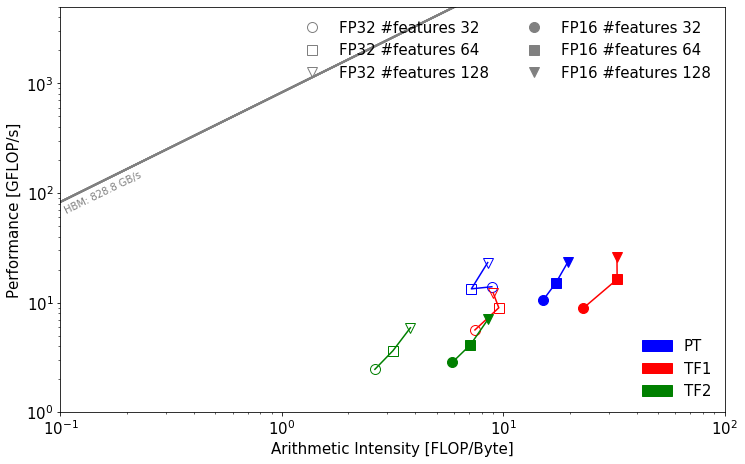

In [8]:
#plot vs num filters
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)

    
features = list(combineddf[["Batch Size", "Time Steps", "Hidden Size", "Pass"]].apply(lambda x: (x["Batch Size"], \
                                                                                          x["Time Steps"], \
                                                                                          x["Hidden Size"], \
                                                                                          x["Pass"]), axis=1).unique())
#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Batch Size" ] == feature[0]) & \
                           (combineddf[ "Time Steps" ] == feature[1]) & \
                           (combineddf[ "Hidden Size" ] == feature[2]) & \
                           (combineddf[ "Pass" ] == feature[3]) ].copy()
    
    #sort data
    selectdf.sort_values("Features", ascending=True, inplace=True)
    
    if len(selectdf["Features"].unique()) == 1:
        continue
    
    #label
    plot_label = 'lstm, b'+str(feature[0])+', t'+str(feature[1])+', h'+str(feature[2])+', '+str(feature[3])
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    #display(selectdf)
    plot_data(plot_file, plot_label, "Features", "#features", selectdf)

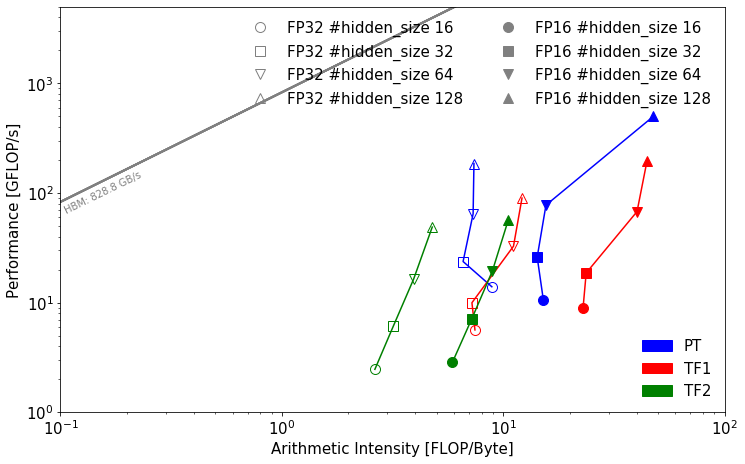

In [9]:
#plot vs num filters
directory= outputdir
try:
    os.stat(directory)
except:
    os.mkdir(directory)

    
features = list(combineddf[["Batch Size", "Time Steps", "Features", "Pass"]].apply(lambda x: (x["Batch Size"], \
                                                                                          x["Time Steps"], \
                                                                                          x["Features"], \
                                                                                          x["Pass"]), axis=1).unique())
#do the plotting
for idx,feature in enumerate(features):
    
    #project the data
    selectdf = combineddf[ (combineddf[ "Batch Size" ] == feature[0]) & \
                           (combineddf[ "Time Steps" ] == feature[1]) & \
                           (combineddf[ "Features" ] == feature[2]) & \
                           (combineddf[ "Pass" ] == feature[3]) ].copy()
    
    #sort data
    selectdf.sort_values("Hidden Size", ascending=True, inplace=True)
    
    if len(selectdf["Hidden Size"].unique()) == 1:
        continue
    
    #label
    plot_label = 'lstm, b'+str(feature[0])+', t'+str(feature[1])+', f'+str(feature[2])+', '+str(feature[3])
    plot_file = os.path.join(directory, plot_label.replace(", ","_"))
    plot_label = None
    #display(selectdf)
    plot_data(plot_file, plot_label, "Hidden Size", "#hidden_size", selectdf)